In [1]:
    from osgeo import gdal
    import numpy as np
    #from mpl_toolkits.basemap import Basemap
    from scipy.interpolate import griddata
    import matplotlib.pyplot as plt
        
    src_lat='/Users/reem/Documents/DeepLearning/code/showResultOnMap/lat_2.npy'
    lat_arr = np.array(np.load(src_lat))
    lat_arr = np.flipud(lat_arr) # down-up flip
    lat_arr_slice=lat_arr[400:1543 ,0:5313] 
    
    src_lon='/Users/reem/Documents/DeepLearning/code/showResultOnMap/lon_2.npy'
    lon_arr = np.array(np.load(src_lon))
    lon_arr = np.flipud(lon_arr) # down-up flip
    lon_arr_slice=lon_arr[400:1543 ,:]
 


#  Deep Learning Result

In [2]:
    
    src_z='/Users/reem/Documents/DeepLearning/code/final_scores.npy'
    z_score_arr = np.array(np.load(src_z))
    z_score_arr = np.flipud(z_score_arr) # down-up flip

    score_slice=z_score_arr[400:1543 ,:]

# Coherence

In [3]:
filepath67 = r"/Users/reem/projAlaith/merged/interferograms/20181108_20181120/filt_fine.cor"
filepath68 = r"/Users/reem/projAlaith/merged/interferograms/20181120_20181202/filt_fine.cor"

ds67 = np.array(gdal.Open(filepath67).ReadAsArray())
ds68 = np.array(gdal.Open(filepath68).ReadAsArray())

CCD=np.subtract(ds67,ds68)
#np.save('subtract_coh1108-1120-1202.npy', coh1)
CCD = np.flipud(CCD)

CCD_slice=CCD[400:1543 ,0:5313]

# GeoTif for CCD

In [7]:

grid_spacing = 0.0003
lon_num=int(2/grid_spacing)
lat_num=int(2/grid_spacing)
lat_points = np.linspace(19,21, lon_num)
lon_points = np.linspace(39,41,lat_num)

# target grid to interpolate to
lon_grid, lat_grid = np.meshgrid(lon_points,lat_points)
lat_grid = np.flipud(lat_grid)# down-up flip

z_score_grid_2 = griddata((lon_arr_slice.flatten(),lat_arr_slice.flatten()),CCD_slice.flatten(),(lon_grid,lat_grid))  

out_file = 'CCD_Final.geotiff'
height,width = np.shape(z_score_grid_2)

drv = gdal.GetDriverByName("GTiff")
ds = drv.Create(out_file, width, height, 1, gdal.GDT_Float64)
# (upper_left_x, x_resolution, x_skew, upper_left_y, y_skew, y_resolution)
# Negative grid spacing in y direction because we've flipped this direction

ds.SetGeoTransform((lon_grid[0,0],grid_spacing,0,lat_grid[0,0],0,-grid_spacing))
ds.SetProjection('EPSG:4326')
ds.GetRasterBand(1).WriteArray(z_score_grid_2)
ds.FlushCache()
del ds

# GeoTif for RNN result

In [6]:

grid_spacing = 0.0003
lon_num=int(2/grid_spacing)
lat_num=int(2/grid_spacing)
lat_points = np.linspace(19,21, lon_num)
lon_points = np.linspace(39,41,lat_num)

# target grid to interpolate to
lon_grid, lat_grid = np.meshgrid(lon_points,lat_points)
lat_grid = np.flipud(lat_grid)

z_score_grid = griddata((lon_arr_slice.flatten(),lat_arr_slice.flatten()),score_slice.flatten(),(lon_grid,lat_grid))  

out_file = 'RNN_Final_LS.geotiff'
height,width = np.shape(z_score_grid)

drv = gdal.GetDriverByName("GTiff")
ds = drv.Create(out_file, width, height, 1, gdal.GDT_Float64)
# (upper_left_x, x_resolution, x_skew, upper_left_y, y_skew, y_resolution)
# Negative grid spacing in y direction because we've flipped this direction

ds.SetGeoTransform((lon_grid[0,0],grid_spacing,0,lat_grid[0,0],0,-grid_spacing))
ds.SetProjection('EPSG:4326')
ds.GetRasterBand(1).WriteArray(z_score_grid)
ds.FlushCache()
del ds

# Histogram

(array([1.608000e+03, 1.069800e+04, 4.315500e+04, 2.000280e+05,
        2.526747e+06, 2.933877e+06, 2.914640e+05, 5.593000e+04,
        8.439000e+03, 8.130000e+02]),
 array([-0.785465  , -0.6298002 , -0.47413546, -0.3184707 , -0.16280591,
        -0.00714114,  0.14852363,  0.3041884 ,  0.45985317,  0.615518  ,
         0.7711827 ], dtype=float32),
 <BarContainer object of 10 artists>)

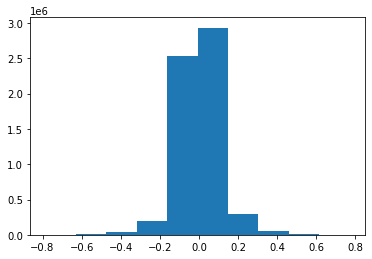

In [6]:
counts, bins = np.histogram(CCD_slice)
plt.hist(bins[:-1], bins, weights=counts)

(array([6.000000e+00, 2.860000e+02, 1.702800e+04, 1.532959e+06,
        4.425460e+06, 9.636600e+04, 6.270000e+02, 2.600000e+01,
        0.000000e+00, 1.000000e+00]),
 array([-12.695 ,  -9.7   ,  -6.71  ,  -3.72  ,  -0.7295,   2.262 ,
          5.254 ,   8.24  ,  11.234 ,  14.23  ,  17.22  ], dtype=float16),
 <BarContainer object of 10 artists>)

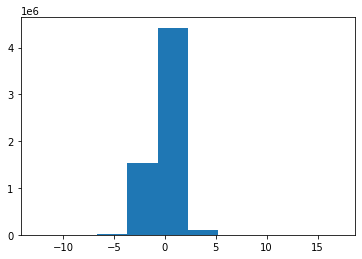

In [5]:
counts, bins = np.histogram(score_slice)
plt.hist(bins[:-1], bins, weights=counts)